# Natural Language Processing

This project is a simple NLP prediction project, with Random Forest classification and XGBoost used as predictive models.  The data consists of hotel reviews, each giving a rating from 1 to 5, and I built the predictive model to make a guess as to what the given rating will be, based on the review.  It's more complex than a simple 0 or 1 binary prediction, and I like that.

I've read people say that "anyone can run xgboost with sklearn" when talking about portfolio projects.  Well then I guess it's time to prove that I'm one of those "anyone."

## Import the libraries

In [497]:
#Standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Libraries for NLP
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#Libraries for Random Forest prediction model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

#Libraries for XGBoost
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read in the dataset

In [498]:
#Read the dataset in
reviews = pd.read_csv('tripadvisor_hotel_reviews.csv')

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None


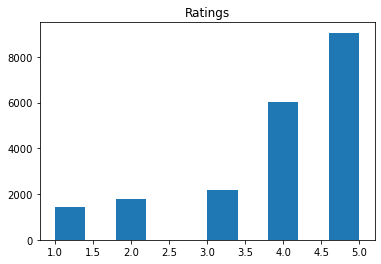

In [499]:
#Print first several rows, examine dataframe specs
print(dataset.head())
print("\n")
print(dataset.info())
#Plot the ratings variable
plt.hist(dataset['Rating'])
plt.title('Ratings')
plt.show()

We see that there are no missing values in the dataframe, and looking at a histogram of the ratings, there aren't any outliers, although 5s are the most common rating.  There's no need to standardize the Ratings, because they're categorical. In addition, we don't need to encode the Ratings variable.

The Descriptive MLR project in my portfolio requires some data cleaning, unlike this squeaky clean data.

Now, let's take a look at the proportion of 5s in the dataset:

In [500]:
print("Proportion of Ratings that are 5s: ")
print('{0:.2f}'.format((reviews['Rating'] == 5).sum()/len(reviews)))

Proportion of Ratings that are 5s: 
0.44


## Clean the text

In the following NLP cleaning, I remove characters, make each review lowercase, remove stopwords (such as I, you, we etc) that do not give any indication of positivity or negativity in predicting ratings, and stem each word.  

What I did that isn't standard procedure is I left most negative words (not, didn't, wasn't, etc) in the dataset, because I think they're important for discerning meaning.  For example, "Next summer, I will stay here," is a far different review from "Next summer, I will not stay here."

I'm going to add the NLP process to an import file eventually, but I wanted to walk you through it in this notebook.

In [501]:
#NLP Cleaning
corpus = []

#The following for loop iterates through each review
for i in range(0, len(reviews)): #20491
  #remove everything that isn't a letter
  message = re.sub('[^a-zA-Z]', ' ', reviews['Review'][i])
  #remove uppercase letters
  message = message.lower()
  #Split message into comma-separated words
  message = message.split()

  #Load stopwords, remove most negatives because I think they'll be important
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  for i in ['not', 'isn', 'wasn', 'won', 'shouldn', 'wouldn', 'weren', 'haven', 
            'hasn', 'hadn', 'aren', 'couldn', 'don', 'doesn', 'didn']:
        all_stopwords.remove(i)
  all_stopwords.append('got')

  #Remove all stopwords from each message and stem the remaining words
  message = [ps.stem(word) for word in message if not word in set(all_stopwords)]
  #Put the message back together and add it to corpus
  message = ' '.join(message)
  corpus.append(message)

In [502]:
#Print stopwords to see if any words need to be left in the dataset (can re-run the above if needed)
print(all_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [503]:
#Print the first few reviews' final form
print(corpus[0] + "\n\n" + corpus[1] + "\n\n" + corpus[2])

nice hotel expens park good deal stay hotel anniversari arriv late even took advic previou review valet park check quick easi littl disappoint non exist view room room clean nice size bed comfort woke stiff neck high pillow not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway mayb noisi neighbor aveda bath product nice not goldfish stay nice touch taken advantag stay longer locat great walk distanc shop overal nice experi pay park night

ok noth special charg diamond member hilton decid chain shot th anniversari seattl start book suit paid extra websit descript not suit bedroom bathroom standard hotel room took print reserv desk show said thing like tv couch ect desk clerk told oh mix suit descript kimpton websit sorri free breakfast kid embassi suit sit room bathroom bedroom unlik kimpton call suit day stay offer correct fals advertis send kimpton prefer guest websit email ask failur provid suit advertis websit reserv descript furnish hard 

## Create the Bag of Words Model/Sparse Matrix

In [504]:
#Split the dataset into the training set and the test set
X = corpus
y = dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

Here, we split the data into the training set and the test set, fitting on training set and transforming it to a sparse matrix, but only transforming the test set to a sparse matrix, not fitting on the test set.  Fitting on the test set was a mistake I saw being made, even in online courses, so I wanted to mention it.

A few parameters that can be tuned, which will have an effect on the accuracy of our prediction model, include the stopwords above, obviously, but also include the size of the training set vs test set, the max features of count vectorizer (that is, the number of words the model recognizes), the number of trees in the random forest model, and the random forest criterion.  I decided, for this model, to leave the test size at 20%, but I will run k-fold cross validation at the end.

I wrote a function, rftuner, where you can enter a list of word counts, and a list of tree counts, as well as the criterion to try, which will print out the accuracy score and time of each attempt.  I've commented out the function call so that it doesn't take up your time unless you actually want to run it--there's an xgtuner as well.  Some of the tunings I've experimented with are listed below.

In [505]:
#Varying the number of trees
#words 2000, trees 100, .548
#words 2000, trees 10, .506
#words 2000, trees 1000, .559 <- highest

#Varying the number of words
#words 4000, trees 100, .546
#words 3000, trees 100, .5459
#words 1000, trees 100, .5508
#words 1500, trees 100, .5528 <- highest
#words 2500, trees 100, .5447

#Varying the number of words using gini coefficient instead of entropy as the Random Forest Criterion
#words 1500, trees 100, gini, .5557
#words 1000, trees 100, gini, .5574
#words 2000, trees 100, gini, .5472
#words 750, trees 100, gini, .5618 <- highest
#words 500, trees 100, gini, .5518

#A couple more variations
#words 750, trees 1000, gini, .5655 <- highest RF model I found
#words 750, trees 100, entropy, .5455

#XGBoost:
#words 750, .595 <- highest model overall
#words 500, .5816
#words 1000, .593

Interestingly enough, 750 words was the sweet spot.  Adding words intuitively seems like it would give the model more data to work with, but once the core words are obtained, extraneous words such as "got" are just going to get in the way of prediction accuracy.  The gini coefficient seemed to be a better criterion for this dataset than entropy, overall.  In addition, 100 trees is the sweet spot whenever I run random forest--1000 trees will add less than 1% accuracy here, but take many times longer to run.

And of course, XGBoost ended up doing better than even Random Forest, which is no surprise.  It takes longer than 100-tree RF, but it's faster than 1000-tree RF, with better accuracy!  14 seconds for 100 trees, 123 seconds for 1000 trees, 95 seconds for XGBoost.

The tuner functions are below so you can try variations yourself (just uncomment the function calls and modify the lists)!

In [506]:
#X_train: the original X training set, in reviews
#rf_train: variable to store X_train within the rf loop
#rf_train_loop: variable to modify rf_train in each iteration and then reread it, without changing the original
#Same goes for y_train, rfy_train, xgy_train, xgy_train_loop, etc

def rftuner(words = [20], trees = [10, 100], coeff = 'entropy', rfx_train = [[]], rfx_test = [[]], rfy_test = [[]], rfy_train = [[]]):
    """Run 1 or more Random Forest models on NLP training and test data.  It will iterate through the list of word counts,
    and the list of trees, outputting the accuracy and time of each model.

    Args:
    words: list. A list of word counts to try for the bag of words model.
    trees: list. A list of tree counts for the random forest model.
    coeff: string. The criterion variable for the rf model.  Common choices are 'entropy' and 'gini' though others exist.
    rfx_train: numpy array.  The training set of texts for the NLP model.
    rfx_test: numpy array.  The test set of texts for the NLP model.
    rfy_train: numpy array.  The training set of response variables to classify.
    rfy_test: numpy array.  The test set of response variables measure predictions against.

    Returns:
    None.
    """
    start_time = time.time()
    for i in words:
        for j in trees:
            #Create bag of words model/sparse matrix
            cv = CountVectorizer(max_features = i)
            rfx_train_loop = cv.fit_transform(rfx_train).toarray()
            rfx_test_loop = cv.transform(rfx_test).toarray()
            classifier = RandomForestClassifier(n_estimators = j, criterion = coeff, random_state = 0)
            classifier.fit(rfx_train_loop, rfy_train)

            #Make prediction vector
            y_pred = classifier.predict(rfx_test_loop)
            print('Random Forest ' + coeff + ' accuracy with ' + str(i) + ' words, ' + str(j) + ' trees: ' 
                  + '{0:.2f} %'.format(accuracy_score(rfy_test, y_pred)*100))
            print('Time: ' + '{0:.2f}'.format(time.time() - start_time))
            start_time = time.time()


def xgtuner(words = [15], xgx_train = [[]], xgx_test = [[]], xgy_test = [[]], xgy_train = [[]]):
    """Run 1 or more XGBoost models on NLP training and test data.  It will iterate through the list of word counts, 
    outputting the accuracy and time of each model.

    Args:
    words: list. A list of word counts to try for the bag of words model.
    xgx_train: numpy array.  The training set of texts for the NLP model.
    xgx_test: numpy array.  The test set of texts for the NLP model.
    xgy_train: numpy array.  The training set of response variables to classify.
    xgy_test: numpy array.  The test set of response variables measure predictions against.

    Returns:
    None.
    """
    start_time = time.time()
    for i in words:
        #Create bag of words model/sparse matrix
        cv = CountVectorizer(max_features = i)
        xgx_train_loop = cv.fit_transform(xgx_train).toarray()
        xgx_test_loop = cv.transform(xgx_test).toarray()
        #XGBoost won't tolerate Ratings 1-5, so we turn them into 0-4:
        xgy_train_loop = xgy_train.copy()
        xgy_test_loop = xgy_test.copy()
        for j in range(0, len(xgy_train_loop)):
            xgy_train_loop[j] = xgy_train_loop[j] -1
        for j in range(0, len(xgy_test_loop)):
            xgy_test_loop[j] = xgy_test_loop[j] - 1
        classifier = XGBClassifier()
        classifier.fit(xgx_train_loop, xgy_train_loop)

        #Make prediction vector
        y_pred = classifier.predict(xgx_test_loop)
        print('XGBoost ' + ' accuracy with ' + str(i) + ' words: ' 
              + '{0:.2f} %'.format(accuracy_score(xgy_test_loop, y_pred)*100))
        print('Time: ' + '{0:.2f}'.format((time.time() - start_time)))
        start_time = time.time()

#uncomment the following line and adjust words list, trees list, and coeff if you want to try multiple runs
#rftuner(words=[750], trees=[100, 1000], coeff='gini', rfx_train = X_train, rfx_test = X_test, rfy_test = y_test, rfy_train = y_train)
        
#uncomment the following line and adjust the words list if you want to try multiple runs    
#xgtuner(words = [750], xgx_train = X_train, xgx_test = X_test, xgy_test = y_test, xgy_train = y_train)

Now I'll use the best model I found, the XGBoost model on 750 words, so that y_pred is available if we wanted to use it for something (remember to use y_pred + 1 if you ever use it against the original data).  I create final X_train, X_test, y_train, and y_test variables so that these cells can be continually rerun for experimentation, without having to reread the dataset above.

## Training the selected model on the Training set

In [507]:
#Create bag of words model/sparse matrix
cv = CountVectorizer(max_features = 750)
X_train_final = cv.fit_transform(X_train).toarray()
X_test_final = cv.transform(X_test).toarray()

#New variable names so I don't contaminate the originals
y_train_final = y_train.copy()
y_test_final = y_test.copy()

#Modify Ratings to be 0-4 instead of 1-5, for XGBoost
for i in range(0, len(y_train_final)):
    y_train_final[i] = y_train_final[i] - 1
for i in range(0, len(y_test_final)):
    y_test_final[i] = y_test_final[i] - 1

#Fit the model
classifier = XGBClassifier()
classifier.fit(X_train_final, y_train_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## Prediction Vector

In [508]:
#Make prediction vector, compare it against y_test
y_pred = classifier.predict(X_test_final)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test_final.reshape(len(y_test_final),1)),1))

[[1 1]
 [2 1]
 [4 3]
 ...
 [3 4]
 [3 3]
 [4 4]]


## Model Evaluation Metrics

In [509]:
#Make the confusion matrix and print the final accuracy score
cm = confusion_matrix(y_test_final, y_pred)
print(cm)
accuracy_score(y_test_final, y_pred)

[[ 188   57   11   11   18]
 [  79  107   61   65   43]
 [  12   79  101  212   67]
 [   3   20   66  575  539]
 [   2   10   11  294 1468]]


0.595023176384484

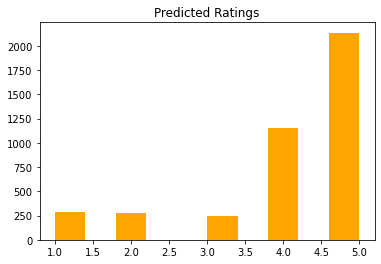

Pretty close!


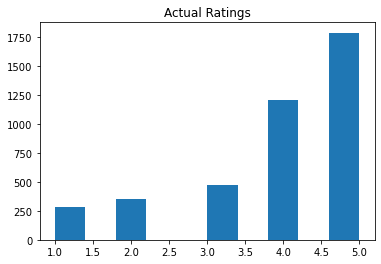

In [534]:
#Plot Predictions
#Adding 1 to y_pred and y_test_final to reflect the original Rating scale
plt.hist(y_pred + 1, color='orange')
plt.title('Predicted Ratings')
plt.show()

print('Pretty close!')

#Plot Actual
plt.hist(y_test_final + 1)
plt.title('Actual Ratings')
plt.show()

K-fold cross validation checks whether the model I selected can generalize across the entire dataset with similar accuracy,
or if I simply got lucky because of the random training/test split that it landed on.  I commented it out so that you wouldn't have to sit through it for 20 minutes unless you want to.

58.71% with standard deviation 1.19!  So our 59% accuracy is on the high end, but still feasible.

In [511]:
#K-fold cross-validation
#scores = cross_val_score(estimator = classifier, X = X_train_final, y = y_train_final, cv = 10)
#print("Accuracy: {:.2f} %".format(scores.mean()*100))
#print("Standard Deviation: {:.2f} %".format(scores.std()*100))

#Accuracy: 58.71 %
#Standard Deviation: 1.19 %

## Conclusions

I'm reasonably content with 59% accuracy, for a dataset with reviews optioned 1-5.  This isn't an accuracy score on a binary response variable; it's on 5 categories, and they're ambiguous as it is.  For example, someone might write a glowing 5-star review and then think "there's always room for improvement" and give a 4, or someone might write a scathing 1-star review and then feel a bit mean and give a 2, and so on.  And if the algorithm picks 4 and it was a 5, there's no measure here for that closeness to the mark.  That would be a good idea for a future program.

Anyway, if you just guessed at each category, you should end up with about a 20% accuracy rate.  If you knew this dataset and knew that 5s were the most common at 44%, you could guess 5 for each one and get a 44% accuracy rate.  So, XGBoost getting 59% is something I'm ambivalent about--I'm pleased that something I implemented got this result, and yet I want it to be better.  It's coming...